# Coherence Change Detection using `ifgramStack.h5`

**Created by: Marin Govorcin, on Feb17,2022**

This notebook shows how we can use the coherence stack for a change\damage detection after natural hazard event, e.g. earthquakes, volcano eruption, flooding, etc..

Coherence change detection (CCD) is obtained as a relative coherence loss between the "normal" pre-event coherence and co-event coherence. Pre-event coherence is calculated for two Synthetic Aperture Radar (SAR) SLCs acquired close before the event, whereas a co-event coherence is obtained between one before and one SAR SLC image.

**Relevant literature:**

1. Yun, et al. (2015a): Rapid Damage Mapping for the 2015 Mw 7.8 Gorkha Earthquake Using Synthetic Aperture Radar Data fromCOSMO–SkyMed and ALOS-2 Satellites, Seismological Research Letters, https://pubs.geoscienceworld.org/srl/article/86/6/1549-1556/315478

2. Yun et al. (2015b): DAMAGE PROXY MAP FROM INTERFEROMETRIC SYNTHETIC APERTURE RADAR COHERENCE, United States Patent US 9.207,318 B2, https://patents.google.com/patent/US9207318

3. Washaya, et al. (2018): Coherence Change-Detection with Sentinel-1 for Natural and Anthropogenic Disaster Monitoring in Urban Areas, Remote Sensing, http://www.mdpi.com/2072-4292/10/7/1026

4. Stephenson et al. (2021): Deep Learning -based Damage Mapping with InSAR Coherence Time Series, IEEE Transactions on Geoscience and Remote Sensing, https://ieeexplore.ieee.org/document/9467551

    if you want to try it..some info on RNN can be found on https://www.tensorflow.org/guide/keras/rnn


In [80]:
# Import needed python modules
%matplotlib inline

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

# mintpy modules
import mintpy
from mintpy.objects import ifgramStack
from mintpy.utils import readfile, writefile, plot, utils as ut

# Check mintpy version
print('MintPy version:', mintpy.__version__)

#############################  Utilities Functions  ######################################
def calc_coherence_change(coherence_stack, 
                          date12_list, 
                          event_date, 
                          method = 'difference',
                          start_date = None,
                          coherence_threshold = None, 
                          min_ccd_value = None, 
                          subset = None, 
                          mask = None, 
                          plot = False,
                          print_msg = False):
    """
    Calculate Coherence Change for the defined eventDate (earthquake, volcano eruption, flooding)

    Input:
      coherence_stack      ::  ndarray           - timeseries coherence stack
      date12_list          ::  list              - dates of SAR acquistions used to generate coherence, example: '20170828_20170904'
      event_date           ::  str               - date of the event for which CCD is calculated, example: '20170904'
                                                   (event: earthquake, volcano eruption, flooding)
      method               ::  str               - method for calculate CCD:
                                                   'difference'         : difference between mean pre- and co- coherence
                                                   'histogram_matching' : histogram matching using pre-event coherence as reference (
                                                                          Yun et al. 2015a and Yun et al. 2015b)
                                                   'ratio'              : ratio between pre- & co- coherence stack (Washaya, et al. 2018)
      start_date           ::  str               - define the first date to get reference, pre-coherence stack: [start_date:event_date], 
                                                   default is first date of timeseries
      coherence_threshold  ::  float/list        - mean spatial coherence threshold used to refine the pre-coherence stack
      min_ccd_value        ::  float             - used to remove the CCD values below the defined value
      subset               ::  list              - calculate CCD on image subset defined as [x1,x2,y1,y2]
      mask                 ::  2D boolean array  - mask the CCD results with external data such as watermask, e.g. waterMask.h5
      plot                 ::  bool              - [True/False] plot intermediate steps (default = False)

    Output:
      ccd                  ::  array             - Coherence Change Detection 
      pre_coherence        ::  array             - Mean Pre-Event Coherence, i.e. before the event
      co_coherence         ::  array             - Mean Co-Event Coherence, i.e. during the event
    """
    vprint = print if print_msg else lambda *args, **kwargs: None
    vprint('\n###############################################')
    vprint('########## Coherence Change Detection #########')
    vprint('###############################################\n')
    
    methods = ['difference', 'histogram_matching', 'ratio']
    if method not in methods:
        raise ValueError(f"Un-recognized CCD method: {method}!")

    # If startDate is not defined, use the first date in timeseries
    if start_date is None:
        start_date = date12_list[0]

    if subset is None:
        subset = [0, coherence_stack.shape[2], 0, coherence_stack.shape[1]]

    ############### FIND and EXTRACT THE NEEDED DATA ##############
    #initilize variables
    pre_event_ix = []
    co_event_ix = []

    vprint('Get pre-event and co-event coherence data')
    # Find coherence datasets before the Event from the start date (defined or begining of timeseries)
    # and  coherence dateset covering the Event: reference SAR acquisition before and secondary after the Event
    for ix, date12 in enumerate(date12_list):
        date1, date2 = date12.split('_')
        if start_date < date1 < event_date and date2 < event_date:
            pre_event_ix.append(ix)
        elif date1 < event_date and date2 > event_date:
            co_event_ix.append(ix)   

    # Coherence stacks
    pre_coherence_stack = coherence_stack[pre_event_ix, subset[2]:subset[3], subset[0]:subset[1]]
    co_coherence_stack  = coherence_stack[co_event_ix, subset[2]:subset[3], subset[0]:subset[1]]

    # Mask coherence stack
    if mask is not None:
        pre_coherence_stack[:, mask == 0] = np.nan
        co_coherence_stack[:, mask == 0]  = np.nan

    #################### Refinement #############################
    if coherence_threshold is not None:
        vprint('Refine pre-event Coherence Stack:')
        pre_coherence_stack_bt = pre_coherence_stack
        mean_coherence_bt = np.nanmean(pre_coherence_stack, axis = (1,2))
        #threshold can be manually defined as list of dates to keep
        if isinstance(coherence_threshold, list) is True:
            pre_coherence_stack = np.take(pre_coherence_stack, coherence_threshold, axis = 0)
        else:
            ix = np.where(mean_coherence_bt > coherence_threshold)
            pre_coherence_stack = np.take(pre_coherence_stack,ix[0], axis = 0)
            vprint('List of dates to keep:',ix[0])
        vprint(f'Number of pre-Event Datasets After Thresholding: {pre_coherence_stack.shape[0]}')
        mean_coherence = np.nanmean(pre_coherence_stack, axis = (1,2))

        if plot:
            from matplotlib.ticker import FormatStrFormatter
            fig, axs = plt.subplots(2, 2, figsize = (8,6), dpi = 100)
            # Histograms
            img1 = axs[0,0].hist(mean_coherence_bt, bins = 50, density = False)
            img2 = axs[0,1].hist(mean_coherence, bins = 20, density = False)
            axs[0,0].set_title('Pre-Event Coherence Before Thresh.')
            axs[0,1].set_title('Pre-Event Coherence After Thresh.')
            axs[0,0].set_ylabel('# Images', fontsize=8)
            for ax in axs[0,:]: 
                ax.set_xlabel('Avg. Spatial Coherence', fontsize=8, weight='bold')
                ax.xaxis.set_label_coords(0.5,0.06)
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

            #CCD plots
            img3 = axs[1,0].imshow(np.mean(pre_coherence_stack_bt, axis = 0), cmap = 'gray', clim = [0,1])
            img4 = axs[1,1].imshow(np.mean(pre_coherence_stack, axis = 0), cmap = 'gray', clim = [0,1])
            for ax in axs[1,:]: 
                ax.set_xticks([]), ax.set_xticklabels([])
                ax.set_yticks([]), ax.set_yticklabels([]) 
   
    ######### Mean pre-event and co-event stack coherence ######
    pre_coherence = np.mean(pre_coherence_stack, axis=0)
    co_coherence = np.mean(co_coherence_stack, axis=0)
    
    ##################### CCD ##################################
    vprint('\nCoherence Change Detection Calculation')
    vprint('     Method: {}'.format(method))   

    # 1. Difference between mean pre_event coh.  - mean. co_event coh.
    if method == 'difference':
        ccd = pre_coherence - co_coherence

    # 2. Histogram matching (Yun et al. 2015a and Yun et al. 2015b)
    # between mean pre_event coh.(ref image) and mean co_event  coh. (matched image.)
    elif method == 'histogram_matching':
        ccd = 1 - exposure.match_histograms(co_coherence, pre_coherence, channel_axis=False)       

    # 3. Ratio between pre- & co-event coherence stack (Washaya, et al. 2018):
    elif method == 'ratio':
        ccd = ((pre_coherence - co_coherence) / co_coherence) * 100

    # ########## Remove values below min_ccd_value #################
    if min_ccd_value is not None:
        vprint('Removing CCD values below {}'.format(min_ccd_value))
        ccd = np.ma.filled(np.ma.masked_where(ccd < min_ccd_value, ccd), fill_value = np.nan)

    ################ Finish ######################################
    vprint('Finish CCD calculation. Output: ccd, pre_coherence, co_coherence')
    return ccd, pre_coherence, co_coherence


def plot_ccd(ccd_data, 
             event_date, 
             metadata, 
             subset = None, 
             method = 'difference',
             coherence_threshold = None,
             title = True, 
             colorbar = True):
             
    """Plot coherence change detection results."""
    
    # Check the length of input array to define number of subplots
    nimg = ccd_data.shape[0] if ccd_data.ndim > 2 else 1        
    fig, axs = plt.subplots(1, nimg, sharey=True, figsize=(10,12), dpi = 100)
    
    # if subset not use select whole scene to plot
    if subset is None:
        subset = [0, ccd_data.shape[2], 0, ccd_data.shape[1]]
      
    for i in range(nimg):
        #Single plot
        if nimg == 1:
            plot_method = method
            data = ccd_data
            ax = axs
        #Multiple plots  
        else:
            plot_method = method[i]
            data = ccd_data[i]
            ax = axs[i]

        img = ax.imshow(data[subset[2]:subset[3], subset[0]:subset[1]], cmap = 'RdGy_r')
        if colorbar == True:
            fig.colorbar(img, ax = ax, location = 'bottom', pad = 0.05)
            
        #flip left_right and up-down based on the orbit direction for radar_coded images
        plot.auto_flip_direction(metadata, ax, print_msg=False)
        
        # Title On/Off
        if title == True:
            if coherence_threshold is not None:
                txt = f'CCD on {event_date} \n {plot_method} \n w/ thresh. {coherence_threshold}'
            else:
                txt = f'CCD on {event_date} \n {plot_method}'
            ax.set_title(txt)
    return

MintPy version: 1.5.0.post11


# 1. Coherence Change Calculation

open ifgramStack file: ifgramStack.h5
reading coherence data from file: /u/trappist-r0/govorcin/CCD/FernandinaSenDT128/mintpy/inputs/ifgramStack.h5 ...

###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data

Coherence Change Detection Calculation
     Method: difference
Finish CCD calculation. Output: ccd, pre_coherence, co_coherence

###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data

Coherence Change Detection Calculation
     Method: histogram_matching
Finish CCD calculation. Output: ccd, pre_coherence, co_coherence

###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data

Coherence Change 

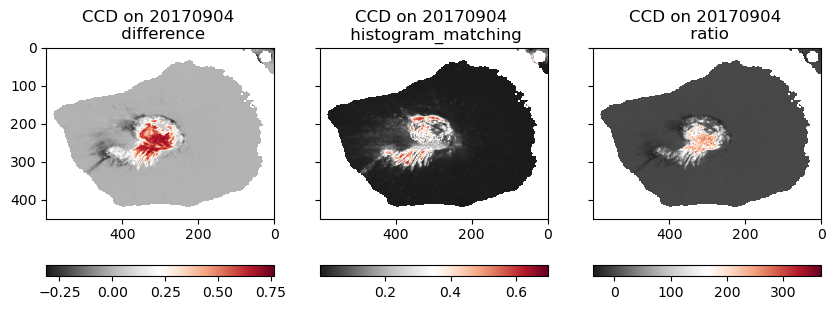

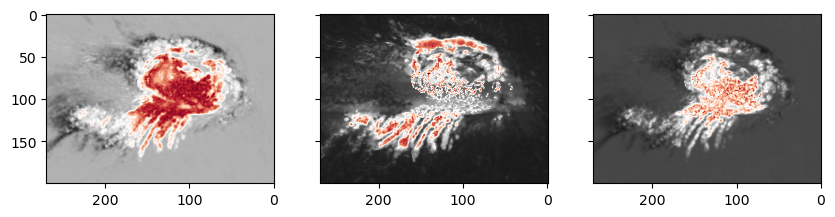

In [81]:
# Change directory to your work_dir
work_dir = os.path.expanduser('/u/trappist-r0/govorcin/CCD/FernandinaSenDT128/mintpy')
os.chdir(work_dir)

# Define input parameters
stack_file = os.path.join(work_dir, 'inputs/ifgramStack.h5')
geom_file = os.path.join(work_dir, 'inputs/geometryRadar.h5')
water_mask = os.path.join(work_dir, 'waterMask.h5')

# Event: vulcano Fernandina eruption on Sep 04. 2017 
event_date = '20170904' 
start_date = '20150101'

stackObj = ifgramStack(stack_file)
stackObj.open()

# Get the coherence date list
date12_list = stackObj.date12List

# Get coherence stack from ifgramStack.h5
coherence_stack = stackObj.read(datasetName='coherence')

#Get mask from waterMask.h5
mask = readfile.read(water_mask)[0]

#Get stack metadata
metadata = stackObj.metadata

# Calculate CCD using three different approaches:
ccd_list = []
pre_coherence_list = []
co_coherence_list = []
methods = ['difference', 'histogram_matching', 'ratio']

for method in methods:
    ccd, pre_coherence, co_coherence = calc_coherence_change(
                                           coherence_stack, date12_list, event_date,
                                           start_date = '20150101', method = method,
                                           coherence_threshold = None, mask = mask,
                                           plot = False, print_msg = True)
    ccd_list.append(ccd)
    pre_coherence_list.append(pre_coherence)
    co_coherence_list.append(co_coherence)

# Plot CCD results
plot_ccd(np.asarray(ccd_list), event_date, metadata, method = methods)

# Zoom-in to the affected area
plot_ccd(np.asarray(ccd_list), event_date, metadata, subset = [200, 470, 150, 350], 
         method = methods, title = False, colorbar = False)

# 2. Refine CCD results with pre-event coherence thresholding

By removing the dates with mean coherence below the defined coherence_threshold, we can refine the pre_event coherence. This can be useful when we want to remove datasets that exbit some coherence changes in the pre-event stack that are not consider as "normal values" at the certain time of year, such as seasonal changes or changes due to other events. This option is good to combine with startDate and subset option to obtain the "best" representation of the pre-event coherence.


###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data
Refine pre-event Coherence Stack:
List of dates to keep: [ 45 108 117 118 120 123 125 127 132 133 134 135 138 139 140 141 142 144
 147 150 153 198 201 202 204 206]
Number of pre-Event Datasets After Thresholding: 26

Coherence Change Detection Calculation
     Method: difference
Finish CCD calculation. Output: ccd, pre_coherence, co_coherence


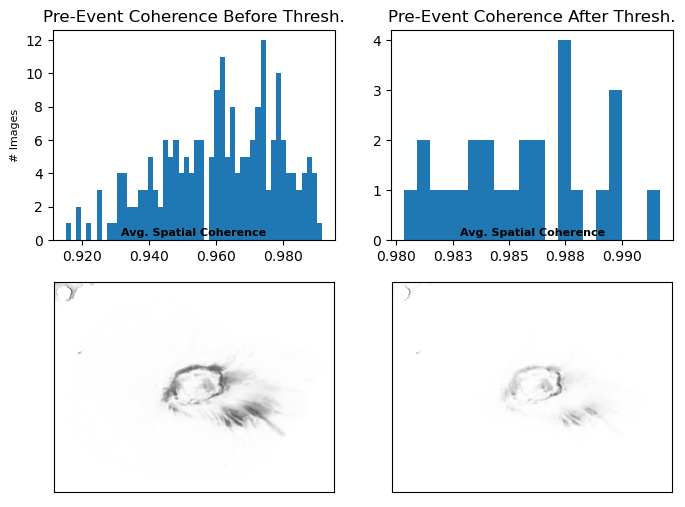

In [82]:
#######################################################################################
#########################       REFINEMENT      ####################################
#######################################################################################

# CCD with threshold value 0.98, example with method 'difference'
# i.e. remove datasets with mean spatial coherence below the defined threshold
threshold = 0.98
ccd, pre_coherence, co_coherence = calc_coherence_change(
                                       coherence_stack, date12_list, event_date,
                                       start_date = '20150101', method = methods[0],
                                       coherence_threshold = threshold, 
                                       mask = mask, plot = True, print_msg=True)

# Use intermediate plots to show an improvement in the pre_coherence around the volcano crater.

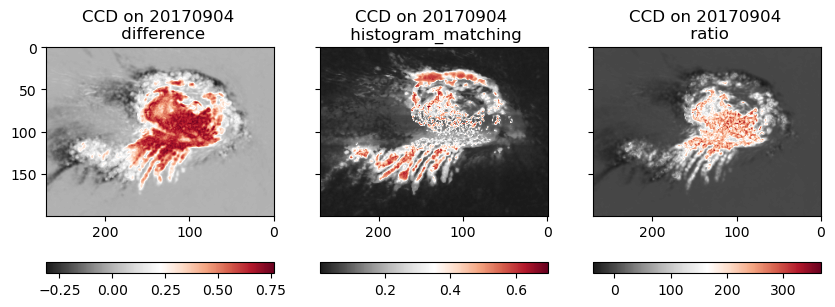

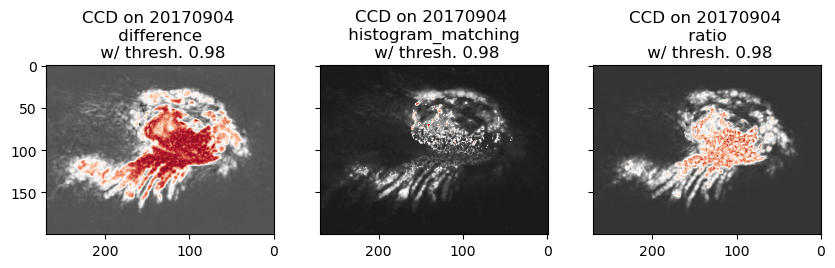

In [83]:
# Calculate CCD using three different approaches with threshold 0.75:
ccd_list2 = []
pre_coherence_list2 = []
co_coherence_list2 = []
methods = ['difference', 'histogram_matching', 'ratio']

for method in methods:
    ccd, pre_coherence, co_coherence = calc_coherence_change(
                                           coherence_stack, date12_list, event_date,
                                           start_date = '20150101', method = method, 
                                           coherence_threshold = threshold, 
                                           mask = mask, plot = False)
    ccd_list2.append(ccd)
    pre_coherence_list2.append(pre_coherence)
    co_coherence_list2.append(co_coherence)
    
# Plot CCD results for the affected area before Thresholding
plot_ccd(np.asarray(ccd_list), event_date, metadata, subset = [200, 470, 150, 350],
         method = methods, title = True, colorbar = True) 

# Plot CCD results for the affected area after Thresholding
plot_ccd(np.asarray(ccd_list2), event_date, metadata, subset = [200, 470, 150, 350],
         method = methods, coherence_threshold = threshold, 
         title = True, colorbar = False)

# 3. Export CCD result to kmz

In [89]:
######################################################################################
##########################       MASKING       ########################################
#######################################################################################
'''
Remove ccd values below defined values
'''

# Calculate CCD using three different approaches with threshold 0.75 and mask
ccd_list = []
pre_coherence_list = []
co_coherence_list = []
methods = ['difference', 'histogram_matching', 'ratio']
min_values = [0.25, 0.05, 170]

for method, min_value in zip(methods, min_values):
    ccd, pre_coherence, co_coherence = calc_coherence_change(
                                            coherence_stack, date12_list, event_date,
                                            start_date = '20150101', method = method, 
                                            coherence_threshold = threshold, mask = mask,
                                            min_ccd_value = min_value, plot = False)
    ccd_list.append(ccd)
    pre_coherence_list.append(pre_coherence)
    co_coherence_list.append(co_coherence)

#######################################################################################
########################       WRITE RESULTS       ####################################
#######################################################################################

# Write the results to h5
attr = readfile.read_attribute(stack_file)

dsDict = {}
for i, method in enumerate(methods):
    dsDict[f'CCD_{method}-{event_date}'] = ccd_list[i]

attr['FILE_TYPE'] = 'coherence'
attr['PROCESOR'] = 'isce'
attr['LENGTH'] = np.asarray(ccd_list).shape[1]
attr['WIDTH'] = np.asarray(ccd_list).shape[2]

output_name = f'cohChange_Fernandina-{event_date}.h5' 

writefile.write(dsDict, out_file = output_name, metadata = attr)

#######################################################################################
########################       GEOCODE RESULTS       ##################################
#######################################################################################

!geocode.py $output_name -l $geom_file

#######################################################################################
#####################       EXPORT RESULTS TO KMZ       ###############################
#######################################################################################
%matplotlib notebook

#Select methods to export to kmz
kmz_method = methods[0] # 0:difference, 1:histogram_matching, 2:ratio
kmz_layer = f'CCD_{kmz_method}-{event_date}'
output_name = 'geo_' + output_name 

!save_kmz.py $output_name $kmz_layer --cbar-label Eruption-Sep2017 -u CCD -c magma_r

delete exsited file: cohChange_Fernandina-20170904.h5
create HDF5 file: cohChange_Fernandina-20170904.h5 with w mode
create dataset /CCD_difference-20170904         of float32    in size of (450, 600)           with compression=None
create dataset /CCD_histogram_matching-20170904 of float32    in size of (450, 600)           with compression=None
create dataset /CCD_ratio-20170904              of float32    in size of (450, 600)           with compression=None
finished writing to cohChange_Fernandina-20170904.h5
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /u/trappist-r0/govorcin/CCD/FernandinaSenDT128/mintpy/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.0005978570860120272, 0.0006249666872659698)
output area extent in (S, N, W, E) in degree: (-0.5498198041859743, -0.20366055138501066, -91.70539823773817, -91.33854279231304)
output file row / column number: (579, 587)
-----------------------